## Chapter 6
### Author: Ou, Dongwen

## Question 1

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# raw data：24 '1'，76 '0'
data = np.array([1] * 24 + [0] * 76)
n = len(data)
B = 10000  # bootstrap # of trials

# save bootstrap's p_hat
bootstrap_phats = np.empty(B)

for b in range(B):
    sample = np.random.choice(data, size=n, replace=True) # new bootstrap sample, size == n
    bootstrap_phats[b] = np.mean(sample)

# 1️⃣ Bootstrap variance estimation
bootstrap_variance = np.var(bootstrap_phats, ddof=1)
print(f"Bootstrap estimate of Var(p̂ - p): {bootstrap_variance:.6f}") # var(p_hat-p) = var(p_hat)
# •ddof=0 → 使用 n 为分母 → 适用于 总体方差
# •ddof=1 → 使用 n - 1 为分母 → 适用于 样本方差

Bootstrap estimate of Var(p̂ - p): 0.001900


95% bootstrap confidence interval for p: (0.160, 0.330)


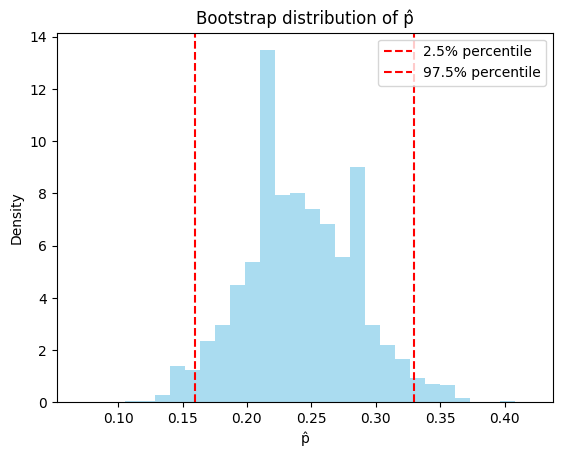

In [17]:
# 2️⃣ Bootstrap CI（Percentile method）
lower = np.percentile(bootstrap_phats, 2.5)
upper = np.percentile(bootstrap_phats, 97.5)
print(f"95% bootstrap confidence interval for p: ({lower:.3f}, {upper:.3f})")
# can also use (2p_hat-upper,2p_hat-lower) to construct 

# visualization
plt.hist(bootstrap_phats, bins=30, density=True, alpha=0.7, color='skyblue')
plt.axvline(lower, color='red', linestyle='--', label='2.5% percentile')
plt.axvline(upper, color='red', linestyle='--', label='97.5% percentile')
plt.title("Bootstrap distribution of p̂")
plt.xlabel("p̂")
plt.ylabel("Density")
plt.legend()
plt.show()

## Question 2

We first calculate $\hat{\beta}$.
Denote $X_{i}=\left(1,X_{1i},X_{2i}\right)'$. Then the log-likelihood function is $$L\left(\beta\right)=\sum_{i=1}^{n}Y_{i}X'_{i}\beta-\sum_{i=1}^{n}\log\left(1+\exp\left(X'_{i}\beta\right)\right).$$

So, $$\nabla L\left(\beta\right)=\sum_{i=1}^{n}X_{i}Y'_{i}-\sum_{i=1}^{n}\frac{\exp\left(X'_{i}\beta\right)}{1+\exp\left(X'_{i}\beta\right)}X_{i} =\sum_{i=1}^{n}(Y_{i}-\frac{\exp\left(X'_{i}\beta\right)}{1+\exp\left(X'_{i}\beta\right)})X_{i},$$and $$\nabla^{2}L\left(\beta\right)=-\sum_{i=1}^{n}\frac{\exp\left(X'_{i}\beta\right)}{\left(1+\exp\left(X'_{i}\beta\right)\right)^{2}}X_{i}X'_{i}.$$
We use Newton method to find $\hat{\beta}$.

$$\nabla_\beta \ell(\beta) = \sum_{i=1}^n (Y_i - \mu_i) X_i = X^\top (Y - \mu)$$

Let $\mu_i = \frac{e^{X_i^\top \beta}}{1 + e^{X_i^\top \beta}},$ then we have $$H(\beta) = -\sum_{i=1}^n \mu_i(1 - \mu_i) X_i X_i^\top,$$

and the matrix form is $$H(\beta) = -X^\top W X$$ where $W: W = \text{diag}(\mu_1(1 - \mu_1), \dots, \mu_n(1 - \mu_n)) \in \mathbb{R}^{n \times n}$

In [34]:
import pandas as pd
data = pd.read_table("/Users/dongwenou/Downloads/Statistical Computing/HW_chapter6_2_2025.txt", sep="\s+", engine='python') 
# 用正则分隔符 \s+ 表示“任意空格”
print(data.head())
Y_input = data["Y"].to_numpy()  # 转换为一维数组
X_input = data.drop(columns="Y")  # 除去原本的 Y 列
X_input.insert(0, "Intercept", 1)  # 加上常数项
X_input = X_input.to_numpy()  # transform to numpy array

print(Y_input.shape, X_input.shape)

   Y     X1     X2
0  1  0.393 -0.283
1  1  1.302  1.152
2  1 -0.594 -1.147
3  1  0.436  0.674
4  1 -0.504 -0.669
(100,) (100, 3)


<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/var/folders/_v/z97dbq5n0msfsdk6k58jt2380000gn/T/ipykernel_3447/3857409736.py:2: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_table("/Users/dongwenou/Downloads/Statistical Computing/HW_chapter6_2_2025.txt", sep="\s+", engine='python')


In [42]:
def gradient(beta, X, Y):
    X_beta = X @ beta
    probs = np.exp(X_beta) / (1 + np.exp(X_beta))
    return X.T @ (Y - probs) # matrix form, faster than summation.

#（Hessian）
def hessian(beta, X):
    X_beta = X @ beta
    probs = np.exp(X_beta) / (1 + np.exp(X_beta))
    W = np.diag((probs * (1 - probs)))
    return -X.T @ W @ X

# Euclidean Norm
def norm(vec):
    return np.linalg.norm(vec)

# Newton
def newton_method(X, Y, tol=1e-5, max_iter=100, init_beta=None):
    n_features = X.shape[1]
    beta = np.zeros(n_features) if init_beta is None else init_beta.copy()
    for _ in range(max_iter):
        grad = gradient(beta, X, Y)
        hess = hessian(beta, X)
        delta = np.linalg.solve(hess, grad)  # solve H⁻¹ * grad
        beta -= delta
        if norm(delta) < tol:
            break
    return beta

# simulation
beta_hat = newton_method(X_input, Y_input)
print("The estimated beta is:", beta_hat)

The estimated beta is: [ 1.00573465 -0.96570808  1.20910634]


In [65]:
# Here we used the parametric bootstrap method:
B = 1000
result = []
for b in range(B):
    boots_Y = Y_input
    for i in range(len(Y_input)): # num_samples
        p = 1 / (1 + np.exp(-X_input[i] @ beta_hat)) # bernoulli p=1
        boots_Y[i] = 1 if np.random.uniform(0, 1) < p else 0
    boots_beta = newton_method(X_input, boots_Y)
    result.append(boots_beta)
print(result[:2])

for i in range(3):
    boots_beta = [item[i] for item in result] # 取对应的参数估计
    q_975 = np.quantile(boots_beta, 0.975)
    q_025 = np.quantile(boots_beta, 0.025)
    print("Confidence Interval for beta_{} is : {}".format(i, [2 * beta_hat[i] - q_975, 2 * beta_hat[i] - q_025]))

[array([ 1.22789857, -1.33701686,  1.61047071]), array([ 0.78180466, -1.11366854,  1.05419349])]
Confidence Interval for beta_0 is : [0.27185783631317584, 1.5012189719323041]
Confidence Interval for beta_1 is : [-1.460282373528667, -0.1955126498548947]
Confidence Interval for beta_2 is : [0.25439404389126086, 1.7172792920564994]
